# PatchSim

In [1]:
import pandas as pd
import patchsim as sim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 5549758 # Total de la población
R0 = 2.68 
alpha = 1/7  # Tasa de infección: tiempo promedio de incubación   
gamma = 1/4.8  # Tasa de recuperación: periodo infeccioso medio.
beta = R0*gamma/N # Tasa de expuestos: la probabilidad de que un susceptible se infecte cuando
                  #                    entra en contacto con un infectado
T=400
print(beta, alpha, gamma)

1.0060498734058914e-07 0.14285714285714285 0.20833333333333334


### cfg.txt - Configuraciones

In [3]:
f = open("files/cfg.txt", "w")
f.write("""
PatchFile=files/pop.txt
NetworkFile=files/net.txt
NetworkType=Static
SeedFile=files/seeds.txt
ParamFile=files/parametros.txt

ExposureRate=1.805e-07
InfectionRate=0.1428
RecoveryRate=0.2083
ScalingFactor=0.0625

StartDate=1
Duration=400

LoadState=False
SaveState=False

OutputFile=resultados.out
OutputFormat=Whole
LogFile=proceso.log
""")
f.close()

### pop.txt - path_df - Tamaño de poblaciones

In [4]:
localidades = pd.read_csv("files/info_local_2020.csv")
df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                    "poblacion":localidades["PopCDR"].values})
df.to_csv("files/pop.txt", header = False, index = False, sep=' ')
N=df["poblacion"].sum()
print("Total pob=",N)
df.T

Total pob= 5549758


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id_localidades,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
poblacion,369936,152168,93928,257646,230318,124375,458427,730237,272242,617260,865749,169295,117041,73041,76972,158021,19142,265916,498044


In [5]:
#Betas
df1 = pd.DataFrame([[R0*gamma/i]*T for i in df["poblacion"]], index=df["id_localidades"])
df1.to_csv("files/parametros.txt", header = False, index = True, sep=' ')

### net.txt - Theta - Matriz de viajes

In [6]:
redes = pd.read_csv("files/cdr_od_loc.csv")

df = pd.DataFrame( {"origen":redes["o_loc"].values, 
                    "destino":redes["d_loc"].values, 
                    "dia":np.zeros(len(redes), dtype=int),
                    "hbw":redes["hbw"].values})

df.to_csv("files/net.txt", header = False, index = False, sep=' ')
df.T.round(1)

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
origen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0,19.0
destino,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
dia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hbw,247173.6,36749.4,4919.9,17711.7,13177.1,3800.7,18947.2,15692.6,7037.5,15783.7,...,14972.8,10242.9,9503.4,4900.9,1597.7,1984.6,4673.5,381.0,9756.3,63926.8


#### seeds.txt - Seed - Primeros infectados

In [7]:
casos = pd.read_csv("files/osb_enftransm-covid-19_17042021.csv", nrows=732872, encoding='latin-1', delimiter=";")
casos = casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                             "FECHA_DIAGNOSTICO":'fecha'})

casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
dia1 = casos["fecha"].min()  # Primer caso de covid en Bogotá  # 6 de marzo de 2020

tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
casos["dia"] = tiempo.dt.days # To int.

datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".
Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='# Casos')  # Cantidad de casos

# Semillas: Cantidad de infectados en los primeros 10 dias para cada localidad.
df = Ncasos[Ncasos["dia"]<=7]    
df.to_csv("files/seeds.txt", header = False, index = False, sep=' ')
df.T

,0,1,2,3,4,5,6,7
dia,0,4,6,6,7,7,7,7
local_id,1,10,8,9,2,10,11,13
# Casos,1,2,1,1,1,3,1,1


### Llamando función PatchSim

In [8]:
configs = sim.read_config('files/cfg.txt')
sim.run_disease_simulation(configs, write_epi=True)

Comenzó simulación
Se cargó archivo de poblaciones
Se cargaron los parámetros
Se importó archivo de conexiones
Se importó archivo de semillas o casos iniciales
Se cargó vacunados 0

Inicializando simulación...
Corriendo en modo determinístico...



245646

In [9]:
infec = np.loadtxt("resultados.out")
infec = pd.DataFrame(infec, index=infec.T[0]).drop(0, axis=1)
infec = infec.sort_index()
infec

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


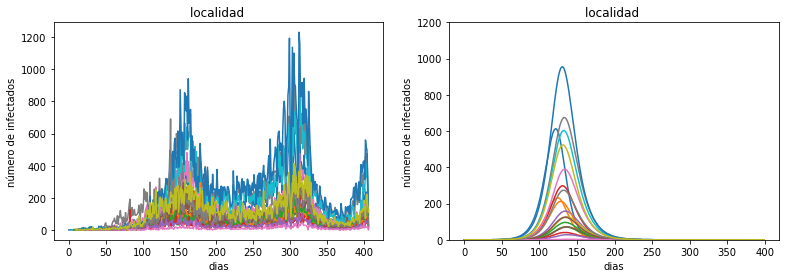

In [15]:
# Graficos

scala = []
ids = localidades["local_id"].values 
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(13,4))
for i in ids:
    
    # Casos reales
    loc = Ncasos[Ncasos["local_id"]==i] # Localidad i
    tiempo = loc["dia"].values
    casos = loc["# Casos"].values
    ax1.plot(tiempo, casos, label=("."))
    ax1.set_title("localidad ")
    ax1.set_xlabel("dias")
    ax1.set_ylabel("número de infectados")
    
    # Casos simulados
    infectados = infec.T[i]
    t = np.arange(0, len(infectados))
    ax2.plot(t, infectados)
    ax2.set_title("localidad ")
    ax2.set_xlabel("dias")
    ax2.set_ylabel("número de infectados")
    
ax2.set_ylim([0,1200])
plt.show()